In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


D:\Program_Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Визуальный анализ ряда

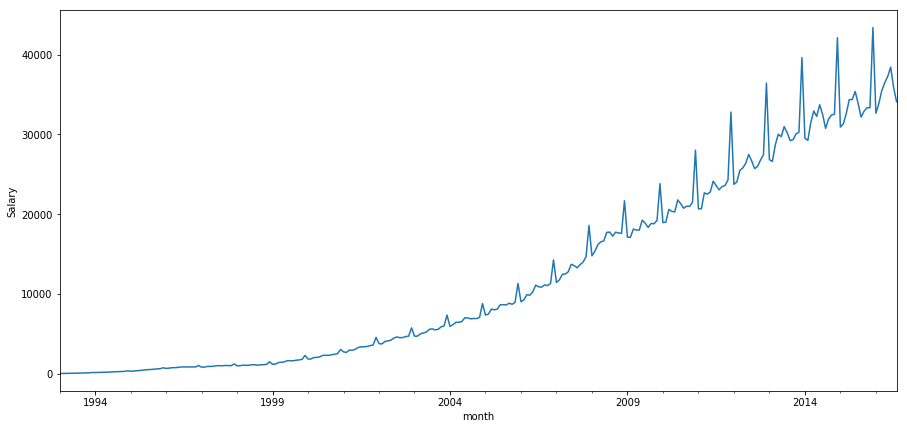

In [10]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


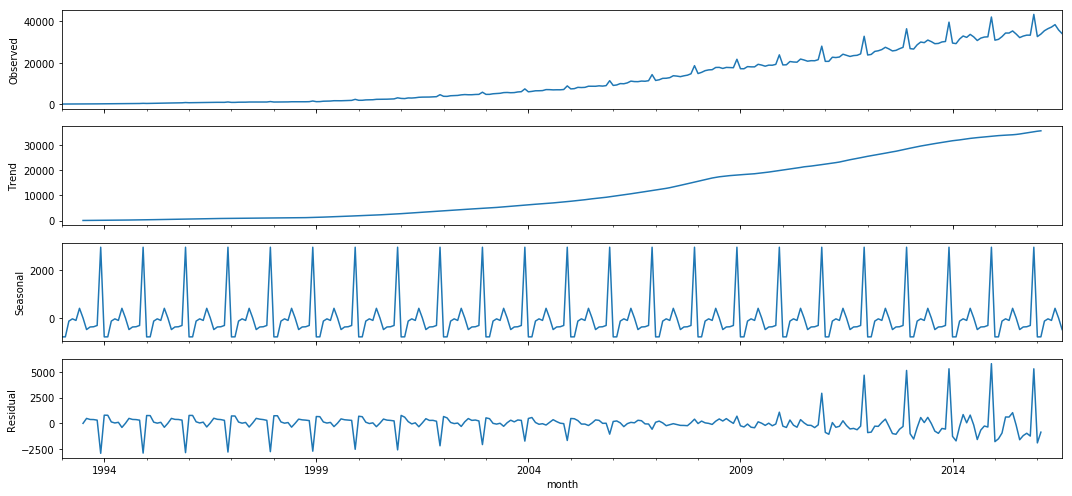

In [11]:
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

# Стабилизация дисперсии (при необходимости)

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


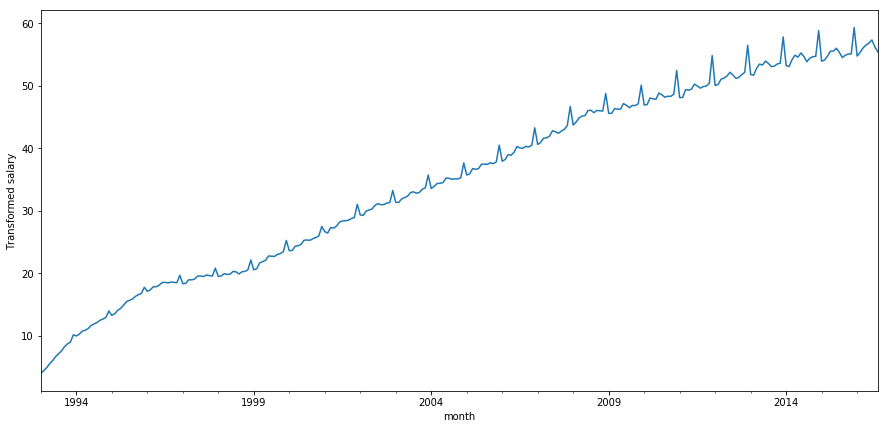

In [12]:
salary['WAG_C_M_box'], lmbda = stats.boxcox(salary.WAG_C_M)
salary.WAG_C_M_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box)[1])

# Выбор порядка дифференцирования

Критерий Дики-Фуллера: p=0.014697


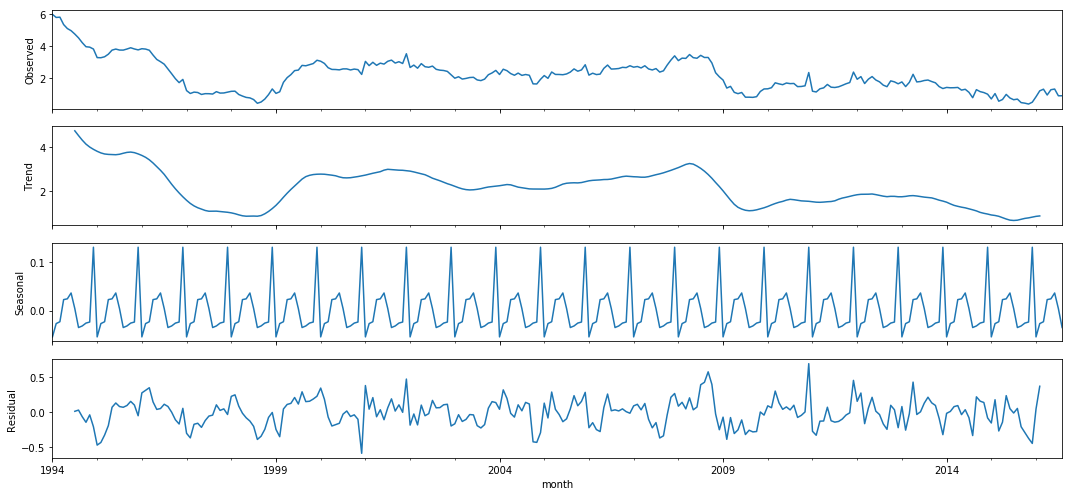

In [13]:
salary['WAG_C_M_box_diff'] = salary.WAG_C_M_box - salary.WAG_C_M_box.shift(12)
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


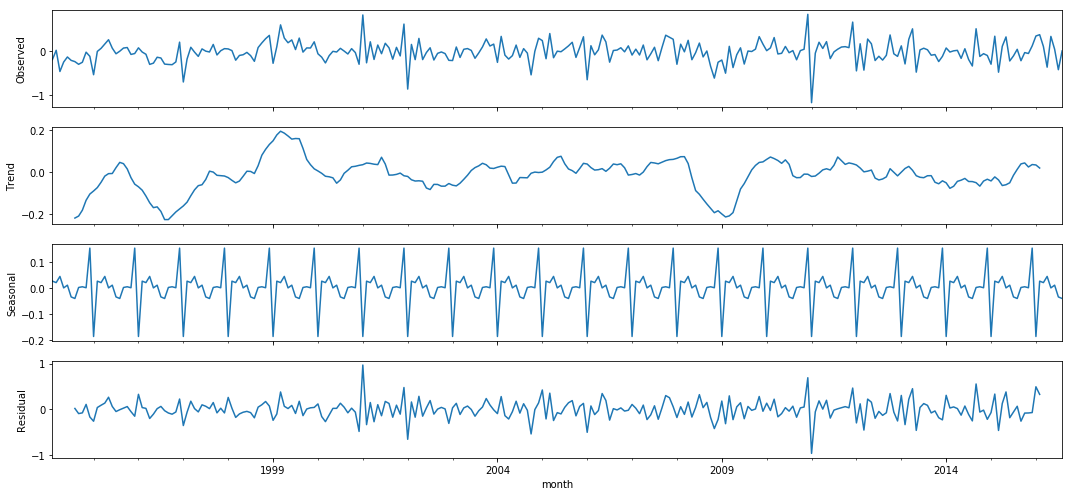

In [14]:
salary['WAG_C_M_box_diff2'] = salary.WAG_C_M_box_diff - salary.WAG_C_M_box_diff.shift(1)
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff2[13:])[1])

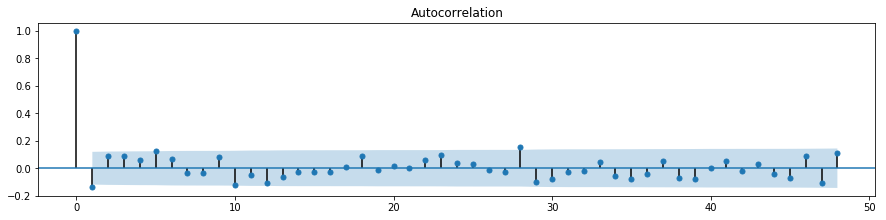

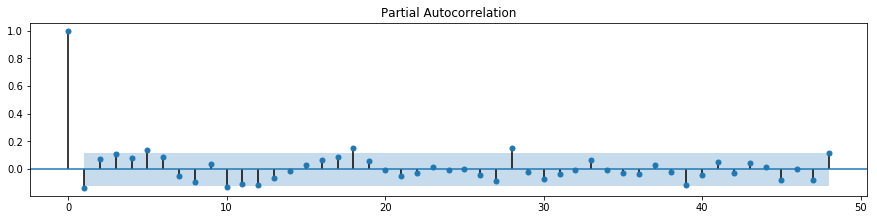

In [15]:
#plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

# Выбор начальных приближений для p,q,P,Q

Начальные приближения: Q=0, q=1, P=3, p=1

In [35]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

In [36]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [37]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 7.75 s


# Обучение и сравнение моделей-кандидатов, выбор победителя

In [38]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
8   (1, 0, 1, 0)  0.340521
4   (0, 1, 1, 0)  1.170768
9   (1, 0, 2, 0)  1.622924
12  (1, 1, 1, 0)  2.021911
5   (0, 1, 2, 0)  2.509650


In [39]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Mon, 25 Dec 2017   AIC                              0.341
Time:                                    19:05:18   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Критерий Стьюдента: p=0.090793
Критерий Дики-Фуллера: p=0.000003


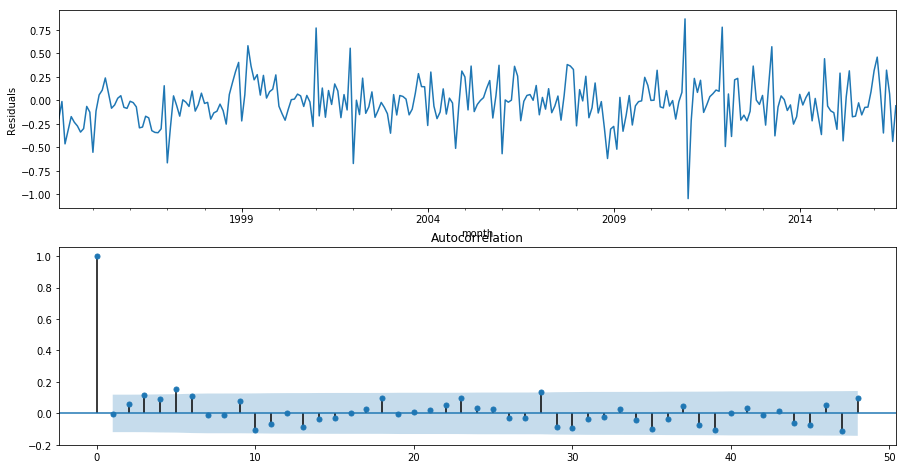

In [40]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

# Прогнозирование с помощью финальной модели.

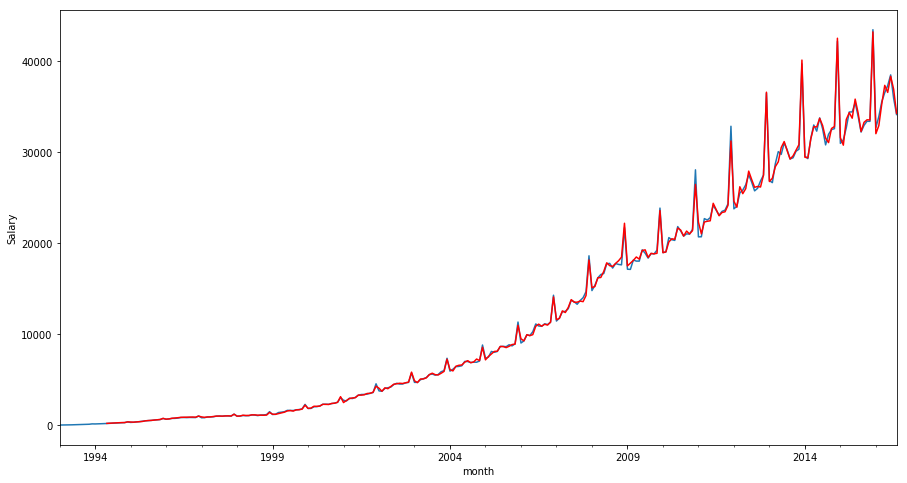

In [45]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
salary.WAG_C_M.plot()
salary.model[16:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

# Прогноз

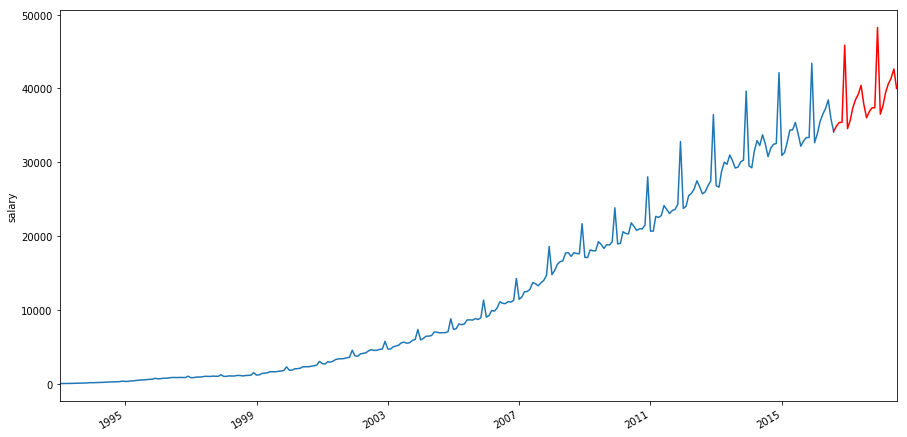

In [71]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns = salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=283, end=308), lmbda)

salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('salary')
pylab.show()

In [60]:
date_list

[datetime.datetime(2016, 8, 1, 0, 0),
 datetime.datetime(2016, 9, 1, 0, 0),
 datetime.datetime(2016, 10, 1, 0, 0),
 datetime.datetime(2016, 11, 1, 0, 0),
 datetime.datetime(2016, 12, 1, 0, 0),
 datetime.datetime(2017, 1, 1, 0, 0),
 datetime.datetime(2017, 2, 1, 0, 0),
 datetime.datetime(2017, 3, 1, 0, 0),
 datetime.datetime(2017, 4, 1, 0, 0),
 datetime.datetime(2017, 5, 1, 0, 0),
 datetime.datetime(2017, 6, 1, 0, 0),
 datetime.datetime(2017, 7, 1, 0, 0),
 datetime.datetime(2017, 8, 1, 0, 0),
 datetime.datetime(2017, 9, 1, 0, 0),
 datetime.datetime(2017, 10, 1, 0, 0),
 datetime.datetime(2017, 11, 1, 0, 0),
 datetime.datetime(2017, 12, 1, 0, 0),
 datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 2, 1, 0, 0),
 datetime.datetime(2018, 3, 1, 0, 0),
 datetime.datetime(2018, 4, 1, 0, 0),
 datetime.datetime(2018, 5, 1, 0, 0),
 datetime.datetime(2018, 6, 1, 0, 0),
 datetime.datetime(2018, 7, 1, 0, 0)]